# Screening insertion locations with PoET

In this tutorial, we'll use PoET to evaluate the acceptibility of insertion locations for the nuclear localization signal `PAAKRVKLD` from c-Myc into a target protein.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json

In [2]:
import openprotein
import openprotein.fasta as fasta

## Connect to the OpenProtein.AI web server

In [3]:
with open('secrets.config', 'r') as f:
    config = json.load(f)

session = openprotein.connect(config['username'], config['password'])

## Define the peptide to insert and the protein to analyze

We'll examine insertion of the nuclear localization signal peptide from c-Myc.

In [4]:
nls = b'PAAKRVKLD'

## Examine insertion sites in aliphatic amidase

In [5]:
name = 'AMIE_PSEAE'
wt = b'MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIPGEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMKISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDGRTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVERLTRSTTGVAQCPVGRLPYEGLEKEA'

print('>' + name)
for i in range(0, len(wt), 80):
    print(wt[i:i+80].decode())

>AMIE_PSEAE
MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIP
GEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMK
ISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDG
RTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVE
RLTRSTTGVAQCPVGRLPYEGLEKEA


### Create the MSA and define an ensemble prompt

To run PoET, we use the OpenProtein API to construct an MSA from homologues of the wildtype sequence using homology search and then define an ensemble prompt containing 10 prompts sampled with default parameters. Query sequences will then be scored conditioned on the fitness landscape represented by the sequences in the prompt.

OpenProtein uses an asynchronous API, where potentially long running functions return a job ID that can be used to query for completed results. The `wait_until_done` function can be used to poll for completion.

In [7]:
# search for homologs to automatically create an MSA for the seed sequence
msa = session.align.create_msa(wt)
print(msa)
msa.wait_until_done(verbose=True)

# create the prompt, set the seed for reproducibility
prompt = msa.sample_prompt(num_ensemble_prompts=10, random_seed=1)
print(prompt)
prompt.wait_until_done(verbose=True)

status=<JobStatus.SUCCESS: 'SUCCESS'> job_id='ca5a70d8-7072-4ac7-be88-ed7fee9f04be' job_type=<JobType.align_align: '/align/align'> created_date=datetime.datetime(2024, 4, 1, 7, 56, 11, 651228) start_date=None end_date=datetime.datetime(2024, 4, 1, 7, 56, 11, 651688) prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None msa_id='ca5a70d8-7072-4ac7-be88-ed7fee9f04be'


Waiting: 100%|██████████| 100/100 [00:00<00:00, 7615.21it/s, status=SUCCESS]


status=<JobStatus.PENDING: 'PENDING'> job_id='a2b5509c-51a2-4fea-9daf-aeaa3f2ecad2' job_type=<JobType.align_prompt: '/align/prompt'> created_date=datetime.datetime(2024, 4, 1, 7, 56, 11, 687433) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None msa_id='a2b5509c-51a2-4fea-9daf-aeaa3f2ecad2' prompt_id='a2b5509c-51a2-4fea-9daf-aeaa3f2ecad2'


Waiting: 100%|██████████| 100/100 [00:21<00:00,  4.55it/s, status=SUCCESS] 


True

### Enumerate and score the insertions

In [8]:
poet = session.embedding.get_model("poet")

In [9]:
queries = [wt]
for i in range(len(wt)):
    q = wt[:i] + nls + wt[i+1:]
    queries.append(q)
len(queries)

347

In [10]:
future_scores = poet.score(prompt=prompt, sequences=queries)
print(future_scores.job)
future_scores.wait_until_done(verbose=True)

status=<JobStatus.SUCCESS: 'SUCCESS'> job_id='62ab8201-3446-493b-8b43-0f685d130fe2' job_type=<JobType.poet_score: '/poet'> created_date=datetime.datetime(2024, 3, 25, 7, 13, 37, 216000) start_date=datetime.datetime(2024, 3, 25, 7, 20, 5, 490139) end_date=datetime.datetime(2024, 3, 25, 7, 20, 22, 155155) prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None parent_id=None s3prefix=None page_size=None page_offset=None num_rows=None result=None n_completed=None


Waiting: 100%|██████████| 100/100 [00:00<00:00, 5304.55it/s, status=SUCCESS]


True

In [14]:
results = future_scores.get()
scores_ensemble = np.stack([r[2] for r in results], axis=0)
scores_ensemble.shape

(347, 10)

Text(0.5, 1.0, 'Insertion Site Tolerance Scan')

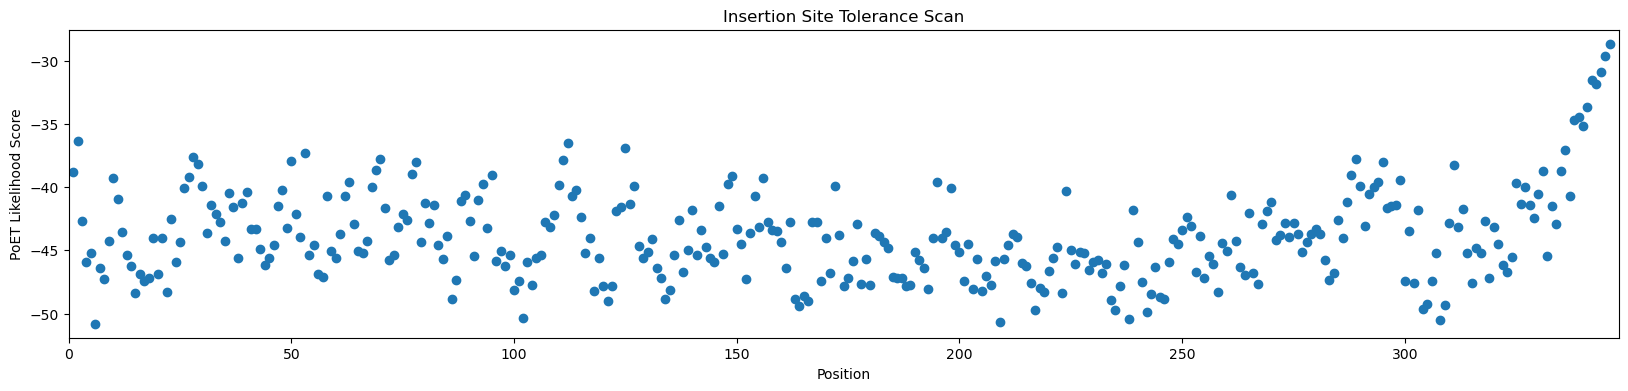

In [15]:
baseline = scores_ensemble[0]
scores = scores_ensemble[1:].mean(axis=-1) - baseline.mean()

_, ax = plt.subplots(figsize=(20, 4))
ax.scatter(np.arange(1, len(wt)+1), scores)
ax.set_xlim(0, len(wt)+2)
plt.xlabel('Position')
plt.ylabel('PoET Likelihood Score')
plt.title('Insertion Site Tolerance Scan')

In [17]:
# sort out the most favorable insertion sites
order = np.argsort(-scores)
print('Score   ', 'Position', sep='\t')
for i in order[:10]:
    print(f'{scores[i]:8.5f}', i+1, sep='\t')

Score   	Position
-28.64021	346
-29.65063	345
-30.90579	344
-31.50744	342
-31.81487	343
-33.61958	341
-34.40652	339
-34.64433	338
-35.18435	340
-36.36819	2


Sensibly, PoET predicts that the C-terminus is likely to be the most tolerated site to insert the NLS peptide. The N-terminus may also be tolerated.

## Examine insertion sites in Cas9

In [18]:
from io import BytesIO

fasta_string = b'''>sp|J7RUA5|CAS9_STAAU CRISPR-associated endonuclease Cas9 OS=Staphylococcus aureus OX=1280 GN=cas9 PE=1 SV=1
MKRNYILGLDIGITSVGYGIIDYETRDVIDAGVRLFKEANVENNEGRRSKRGARRLKRRR
RHRIQRVKKLLFDYNLLTDHSELSGINPYEARVKGLSQKLSEEEFSAALLHLAKRRGVHN
VNEVEEDTGNELSTKEQISRNSKALEEKYVAELQLERLKKDGEVRGSINRFKTSDYVKEA
KQLLKVQKAYHQLDQSFIDTYIDLLETRRTYYEGPGEGSPFGWKDIKEWYEMLMGHCTYF
PEELRSVKYAYNADLYNALNDLNNLVITRDENEKLEYYEKFQIIENVFKQKKKPTLKQIA
KEILVNEEDIKGYRVTSTGKPEFTNLKVYHDIKDITARKEIIENAELLDQIAKILTIYQS
SEDIQEELTNLNSELTQEEIEQISNLKGYTGTHNLSLKAINLILDELWHTNDNQIAIFNR
LKLVPKKVDLSQQKEIPTTLVDDFILSPVVKRSFIQSIKVINAIIKKYGLPNDIIIELAR
EKNSKDAQKMINEMQKRNRQTNERIEEIIRTTGKENAKYLIEKIKLHDMQEGKCLYSLEA
IPLEDLLNNPFNYEVDHIIPRSVSFDNSFNNKVLVKQEENSKKGNRTPFQYLSSSDSKIS
YETFKKHILNLAKGKGRISKTKKEYLLEERDINRFSVQKDFINRNLVDTRYATRGLMNLL
RSYFRVNNLDVKVKSINGGFTSFLRRKWKFKKERNKGYKHHAEDALIIANADFIFKEWKK
LDKAKKVMENQMFEEKQAESMPEIETEQEYKEIFITPHQIKHIKDFKDYKYSHRVDKKPN
RELINDTLYSTRKDDKGNTLIVNNLNGLYDKDNDKLKKLINKSPEKLLMYHHDPQTYQKL
KLIMEQYGDEKNPLYKYYEETGNYLTKYSKKDNGPVIKKIKYYGNKLNAHLDITDDYPNS
RNKVVKLSLKPYRFDVYLDNGVYKFVTVKNLDVIKKENYYEVNSKCYEEAKKLKKISNQA
EFIASFYNNDLIKINGELYRVIGVNNDLLNRIEVNMIDITYREYLENMNDKRPPRIIKTI
ASKTQSIKKYSTDILGNLYEVKSKKHPQIIKKG'''

with BytesIO(fasta_string) as f:
    names, sequences = fasta.parse(f)
name = names[0].decode()
wt = sequences[0]

print('>' + name)
for i in range(0, len(wt), 80):
    print(wt[i:i+80].decode())

>sp|J7RUA5|CAS9_STAAU CRISPR-associated endonuclease Cas9 OS=Staphylococcus aureus OX=1280 GN=cas9 PE=1 SV=1
MKRNYILGLDIGITSVGYGIIDYETRDVIDAGVRLFKEANVENNEGRRSKRGARRLKRRRRHRIQRVKKLLFDYNLLTDH
SELSGINPYEARVKGLSQKLSEEEFSAALLHLAKRRGVHNVNEVEEDTGNELSTKEQISRNSKALEEKYVAELQLERLKK
DGEVRGSINRFKTSDYVKEAKQLLKVQKAYHQLDQSFIDTYIDLLETRRTYYEGPGEGSPFGWKDIKEWYEMLMGHCTYF
PEELRSVKYAYNADLYNALNDLNNLVITRDENEKLEYYEKFQIIENVFKQKKKPTLKQIAKEILVNEEDIKGYRVTSTGK
PEFTNLKVYHDIKDITARKEIIENAELLDQIAKILTIYQSSEDIQEELTNLNSELTQEEIEQISNLKGYTGTHNLSLKAI
NLILDELWHTNDNQIAIFNRLKLVPKKVDLSQQKEIPTTLVDDFILSPVVKRSFIQSIKVINAIIKKYGLPNDIIIELAR
EKNSKDAQKMINEMQKRNRQTNERIEEIIRTTGKENAKYLIEKIKLHDMQEGKCLYSLEAIPLEDLLNNPFNYEVDHIIP
RSVSFDNSFNNKVLVKQEENSKKGNRTPFQYLSSSDSKISYETFKKHILNLAKGKGRISKTKKEYLLEERDINRFSVQKD
FINRNLVDTRYATRGLMNLLRSYFRVNNLDVKVKSINGGFTSFLRRKWKFKKERNKGYKHHAEDALIIANADFIFKEWKK
LDKAKKVMENQMFEEKQAESMPEIETEQEYKEIFITPHQIKHIKDFKDYKYSHRVDKKPNRELINDTLYSTRKDDKGNTL
IVNNLNGLYDKDNDKLKKLINKSPEKLLMYHHDPQTYQKLKLIMEQYGDEKNPLYKYYEETGNYLTKYSKKDNGPVIKKI


### Create the MSA and define an ensemble prompt

In [ ]:
# search for homologs to automatically create an MSA for the seed sequence
msa = session.align.create_msa(wt)
print(msa)
msa.wait_until_done(verbose=True)

# create the prompt, set the seed for reproducibility
prompt = msa.sample_prompt(num_ensemble_prompts=10, random_seed=1)
print(prompt)
prompt.wait_until_done(verbose=True)

status=<JobStatus.SUCCESS: 'SUCCESS'> job_id='100703c8-93e2-438d-980b-5da3a654f240' job_type=<JobType.align: '/align/align'> created_date=datetime.datetime(2024, 3, 25, 7, 20, 31, 541591) start_date=None end_date=datetime.datetime(2024, 3, 25, 7, 20, 31, 541835) prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None msa_id='100703c8-93e2-438d-980b-5da3a654f240'


Waiting: 100%|██████████| 100/100 [00:00<00:00, 7171.34it/s, status=SUCCESS]


status=<JobStatus.PENDING: 'PENDING'> job_id='2f87c58c-0ca2-4e66-9c6b-6b145ac7adbe' job_type=<JobType.align_prompt: '/align/prompt'> created_date=datetime.datetime(2024, 3, 25, 7, 20, 31, 580251) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None msa_id='2f87c58c-0ca2-4e66-9c6b-6b145ac7adbe' prompt_id='2f87c58c-0ca2-4e66-9c6b-6b145ac7adbe'


Waiting: 100%|██████████| 100/100 [02:31<00:00,  1.52s/it, status=SUCCESS] 


True

### Enumerate and score the insertions

In [19]:
queries = [wt]
for i in range(len(wt)):
    q = wt[:i] + nls + wt[i+1:]
    queries.append(q)
len(queries)

1054

In [20]:
future_scores = poet.score(prompt=prompt, sequences=queries)
print(future_scores.job)
future_scores.wait_until_done(verbose=True)

status=<JobStatus.SUCCESS: 'SUCCESS'> job_id='3dbefbed-d7f3-431c-a4d8-ed9e1cbcf182' job_type=<JobType.poet_score: '/poet'> created_date=datetime.datetime(2024, 3, 25, 7, 23, 8, 8314) start_date=datetime.datetime(2024, 3, 25, 7, 28, 24, 513588) end_date=datetime.datetime(2024, 3, 25, 7, 29, 15, 154194) prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None parent_id=None s3prefix=None page_size=None page_offset=None num_rows=None result=None n_completed=None


Waiting: 100%|██████████| 100/100 [00:00<00:00, 6865.44it/s, status=SUCCESS]


True

In [21]:
results = future_scores.get()
scores_ensemble = np.stack([r[2] for r in results], axis=0)
scores_ensemble.shape

(1054, 10)

Text(0.5, 1.0, 'Insertion Site Tolerance Scan')

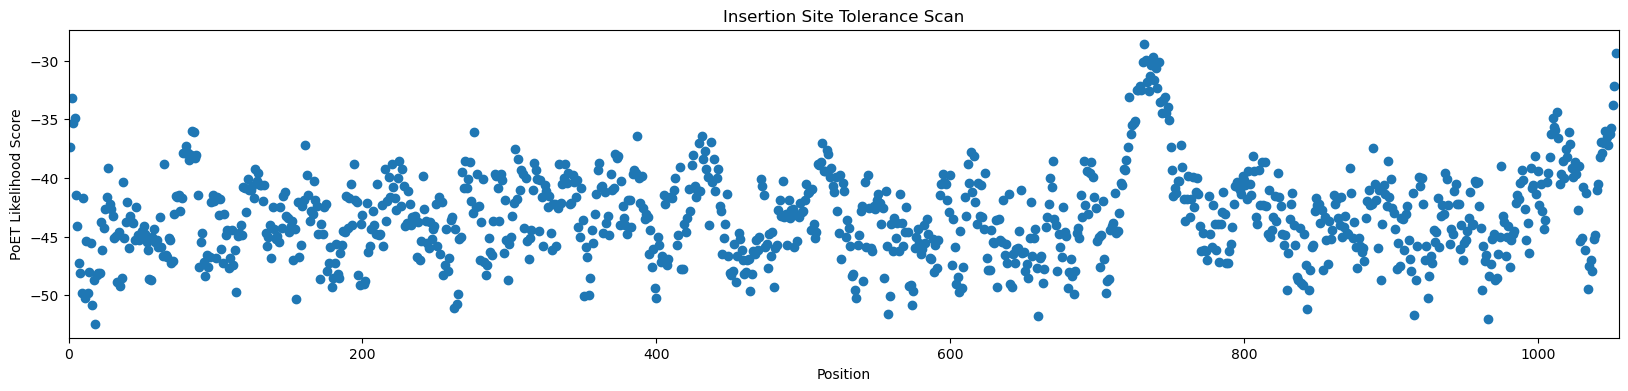

In [22]:
baseline = scores_ensemble[0]
scores = scores_ensemble[1:].mean(axis=-1) - baseline.mean()

_, ax = plt.subplots(figsize=(20, 4))
ax.scatter(np.arange(1, len(wt)+1), scores)
ax.set_xlim(0, len(wt)+2)
plt.xlabel('Position')
plt.ylabel('PoET Likelihood Score')
plt.title('Insertion Site Tolerance Scan')

In [23]:
# sort out the most favorable insertion sites
order = np.argsort(-scores)
print('Score   ', 'Position', sep='\t')
for i in order[:10]:
    print(f'{scores[i]:8.5f}', i+1, sep='\t')

Score   	Position
-28.56653	732
-29.34781	1053
-29.71613	738
-29.94740	733
-30.11392	742
-30.16401	731
-30.36705	737
-30.62352	740
-31.28050	736
-31.69111	739


For Cas9, PoET predicts that the best tolerated insertion site is at position 732 or position 738. The C-terminus is also predited to be amongst the best tolerated. Examining the plot also shows that the N-terminus should also be tolerated. Engineered Cas9 proteins have used both N- and C-terminal nuclear localization signals, but the internal 732/738 sites are novel predictions.

Examining the crystal structure of this Cas9, [5AXW](https://www.rcsb.org/3d-view/5AXW/1), shows that the the 732-738 stretch is a surface exposed loop, a plausible insertion location.